In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Rekurencyjne sieci neuronowe

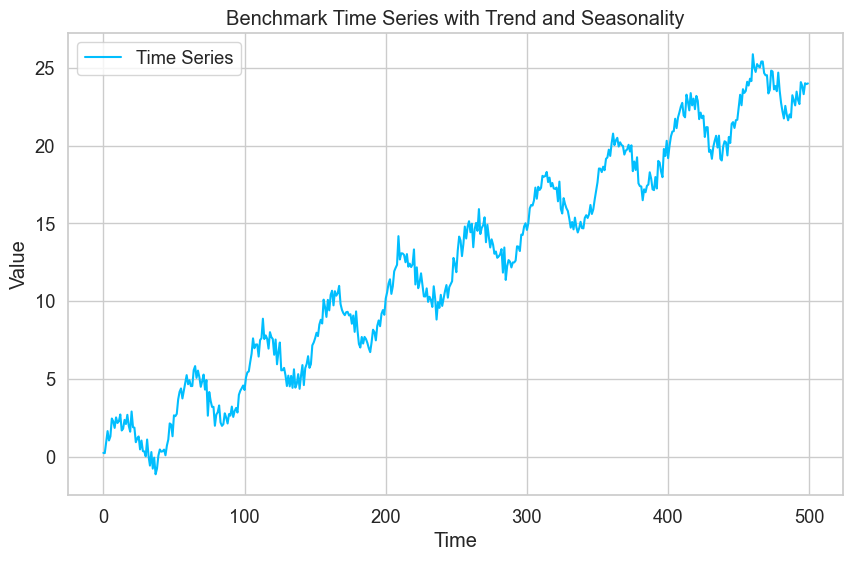

In [3]:
from functions_for_notebook import create_benchmark_data

%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

Colour_Palette = ["#01BEFE", "#FF7D00", "#FFDD00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(Colour_Palette))

n_points = 500
data, time_series, t = create_benchmark_data(n_points)


# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data["Time"], data["Value"], label="Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Benchmark Time Series with Trend and Seasonality")
plt.legend()
plt.show()

# Save the data to a CSV file
data.to_csv("benchmark_time_series.csv", index=False)

In [4]:
from functions_for_notebook import data_transformation

(
    train_data,
    test_data,
    scaled_train,
    scaled_test,
    dataset_train,
    dataset_test,
    scaler,
) = data_transformation(data, 0.8)

In [5]:
from functions_for_notebook import create_sequences

sequence_length = 50  # Number of time steps to look back
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

print(y_train[0])

[0.17291092]


In [6]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([350, 50, 1]) torch.Size([350, 1])
torch.Size([50, 50, 1]) torch.Size([50, 1])


In [7]:
from models import SimpleRNN

input_size = 1
hidden_size = 256
output_size = 1
model_rnn = SimpleRNN(input_size, hidden_size, output_size)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model_rnn.parameters(), lr=1e-3)  # Learning rate
batch_size = 32  # Adjusted batch size
# Wraping in torch dataset data type
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 50  # Increased number of epochs
train_hist = []
test_hist = []

Cuda check

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce RTX 4060 Ti


In [9]:
# Załadowanie modelu do Cuda
model_rnn.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_rnn.parameters(), lr=0.001)
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0.0
    model_rnn.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model_rnn(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_hist.append(average_loss)

    model_rnn.eval()
    with torch.no_grad():
        total_test_loss = 0.0

        for batch_X_test, batch_y_test in test_loader:
            batch_X_test, batch_y_test = (
                batch_X_test.to(device),
                batch_y_test.to(device),
            )
            predictions_test = model_rnn(batch_X_test)
            test_loss = loss_fn(predictions_test, batch_y_test)

            total_test_loss += test_loss.item()

        average_test_loss = total_test_loss / len(test_loader)
        test_hist.append(average_test_loss)

    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}"
        )

Epoch [10/100] - Training Loss: 0.0010, Test Loss: 0.0107
Epoch [20/100] - Training Loss: 0.0011, Test Loss: 0.0098
Epoch [30/100] - Training Loss: 0.0009, Test Loss: 0.0106
Epoch [40/100] - Training Loss: 0.0011, Test Loss: 0.0116
Epoch [50/100] - Training Loss: 0.0009, Test Loss: 0.0118
Epoch [60/100] - Training Loss: 0.0011, Test Loss: 0.0112
Epoch [70/100] - Training Loss: 0.0010, Test Loss: 0.0101
Epoch [80/100] - Training Loss: 0.0008, Test Loss: 0.0100
Epoch [90/100] - Training Loss: 0.0009, Test Loss: 0.0100
Epoch [100/100] - Training Loss: 0.0008, Test Loss: 0.0092


In [10]:
from functions_for_notebook import print_gpu_memory

print_gpu_memory()
torch.cuda.empty_cache()
print_gpu_memory()

Allocated memory: 17.90 MB
Cached memory: 84.00 MB
Allocated memory: 17.90 MB
Cached memory: 22.00 MB


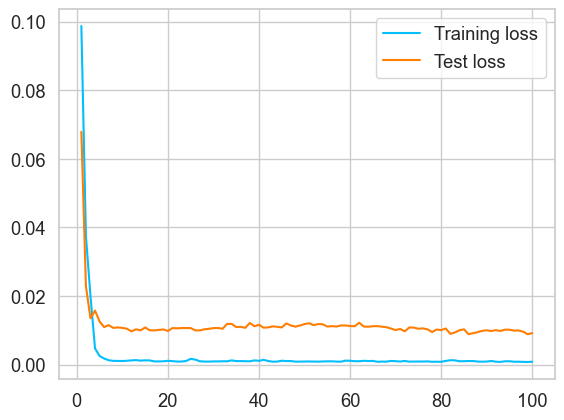

In [11]:
x = np.linspace(1, num_epochs, num_epochs)
plt.plot(x, train_hist, scalex=True, label="Training loss")
plt.plot(x, test_hist, label="Test loss")
plt.legend()
plt.show()

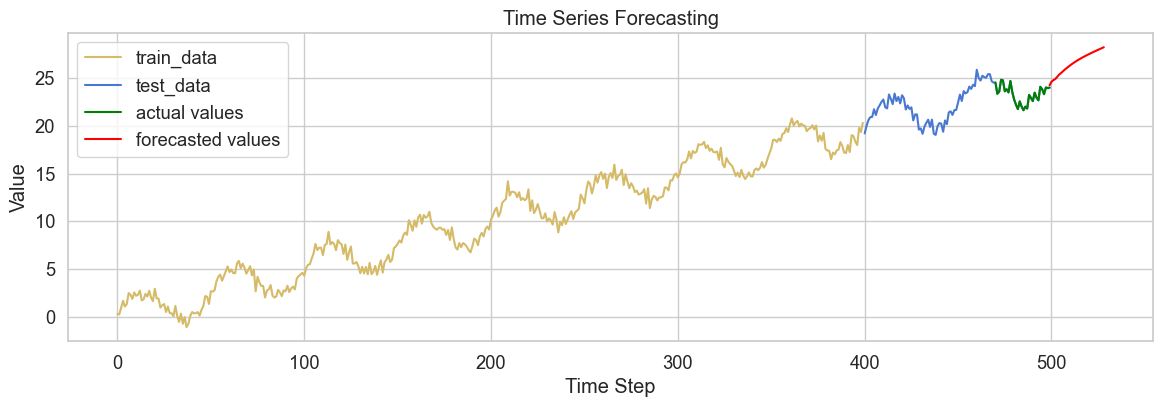

RMSE: 0.0973
R² Score: 0.6024


In [12]:
from functions_for_notebook import forecast_model, model_eval

forecasted_values = forecast_model(
    model=model_rnn, device=device, X_test=X_test, num_forecast_steps=30
)

last_number = test_data.index[-1]
periods = 29
future_dates = pd.Series(range(last_number, last_number + 1 + periods))

plt.rcParams["figure.figsize"] = [14, 4]
plt.plot(train_data.index, train_data.Value, label="train_data", color="y")
plt.plot(test_data.index, test_data.Value, label="test_data", color="b")
plt.plot(
    test_data.index[-30:], test_data.Value[-30:], label="actual values", color="green"
)
plt.plot(
    future_dates,
    scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1)).flatten(),
    label="forecasted values",
    color="red",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

rmse, r2 = model_eval(model=model_rnn, X_test=X_test, y_test=y_test, device=device)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

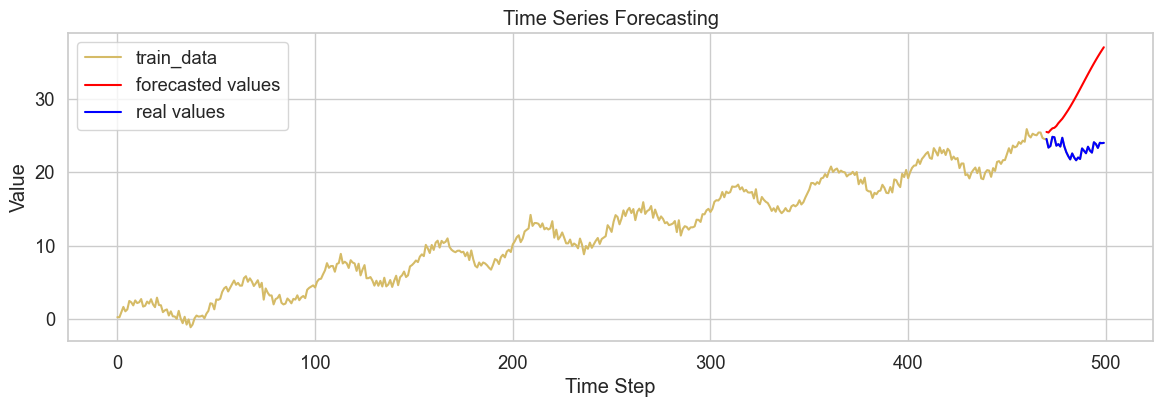

RMSE: 8.2475
R² Score: -81.0990


In [13]:
from functions_for_notebook import model_eval_raw_data, stats
# Create a DataFrame

historical_data, forecasted_values_scaled, real_values = model_eval_raw_data(
    model=model_rnn,
    data=data,
    device=device,
    prediction_start=80,
    prediction_end=30,
    scaler=scaler,
)
future_dates = data.index[-30:]


plt.plot(data.index, data.Value, label="train_data", color="y")
# plt.plot(historical_data.index, historical_data.Value, label="actual values", color="green")
plt.plot(
    future_dates,
    forecasted_values_scaled,
    label="forecasted values",
    color="red",
)
plt.plot(
    future_dates,
    real_values.Value,
    label="real values",
    color="blue",
)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.title("Time Series Forecasting")
plt.grid(True)
plt.show()

r2, rmse = stats(
    real_values=real_values.Value, test_predictions=forecasted_values_scaled
)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")